# Plot

In [23]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os,glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

delphesDir = os.path.abspath("./MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [2]:
inputFiles = glob.glob('./DMSimp_vector_NWA/Events/run*/*.root')
inputDict = {}
for f in inputFiles:
    mMed,mDM = os.path.basename(f).split('_')[1:3]
    inputDict[eval(mMed)] = f
inputDict = dict(sorted(inputDict.items()))

In [3]:
deltaEta = {mMed : [] for mMed in inputDict}
mList = {mMed : [] for mMed in inputDict}
zboost = {mMed : [] for mMed in inputDict}
xsec = {}
br = {}
acc = {}

for mMed,inputFile in inputDict.items():
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    npass = 0
    n_acc = 0
    total_xsec = 0.0
    for ievt in range(nevts):
        tree.GetEntry(ievt)
        weightPB = tree.Weight.At(1).Weight
        total_xsec += weightPB
        zpList = []
        zpDaughters = {}
        for iptc in range(tree.Particle.GetEntries()):
#             if iptc > 100:
#                 break
            p = tree.Particle.At(iptc)
#             print(iptc,':',p.PID,'->',p.D1,p.D2)
            if abs(p.PID) == 55 and (p.D1 != p.D2):
                zpList.append(p)
                zpDaughters[len(zpList)-1] = []
                for idaughter in range(p.D1,p.D2+1):
                    zpDaughters[len(zpList)-1].append(tree.Particle.At(idaughter))
                    
                                                      
        if len(zpList) != 1:
            print('More than one mediator found in event',ievt)
            break
        zp = zpList[0]
        mz = np.sqrt(zp.E**2 - zp.Px**2 - zp.Py**2 - zp.Pz**2)
        beta = np.sqrt(zp.Px**2 + zp.Py**2 + zp.Pz**2)/zp.E
        daughters = zpDaughters[0]
        if len(daughters) != 2:
            print('More than one mediator found in event',ievt)
            break

        if any(abs(d.PID) in [6,52] for d in daughters):
            continue
            
        npass += 1
        mList[mMed].append(mz)
        zboost[mMed].append(beta)
        dEta = abs(daughters[0].Eta-daughters[1].Eta)
        deltaEta[mMed].append(dEta)
        
        if dEta > 1.1:
            continue
        if any(abs(d.Eta) > 2.5 for d in daughters):
            continue
        n_acc += 1
        

    print('Mass = %1.0f' %mMed, 'Acceptance = %1.2f' %(float(n_acc)/npass))
    print('BR = ',float(npass)/nevts)
    print('Total xsec (pb) = %1.3e' %total_xsec)
    print('sigma*BR*Acc = %1.3e' %(total_xsec*n_acc/nevts))
    print()
    xsec[mMed] = total_xsec
    br[mMed] = float(npass)/nevts
    acc[mMed] = float(n_acc)/npass
    f.Close()
            

Mass = 500 Acceptance = 0.47
BR =  0.4424
Total xsec (pb) = 2.468e+02
sigma*BR*Acc = 5.079e+01

Mass = 2000 Acceptance = 0.51
BR =  0.4418
Total xsec (pb) = 6.636e-01
sigma*BR*Acc = 1.481e-01

Mass = 3000 Acceptance = 0.48
BR =  0.4392
Total xsec (pb) = 5.952e-02
sigma*BR*Acc = 1.263e-02

Mass = 4000 Acceptance = 0.51
BR =  0.4352
Total xsec (pb) = 6.984e-03
sigma*BR*Acc = 1.535e-03

Mass = 5000 Acceptance = 0.49
BR =  0.4326
Total xsec (pb) = 8.767e-04
sigma*BR*Acc = 1.843e-04

Mass = 6000 Acceptance = 0.50
BR =  0.4534
Total xsec (pb) = 1.090e-04
sigma*BR*Acc = 2.474e-05



### ATLAS values

In [26]:
atlas_data = np.genfromtxt('./sigmaBRA_DMmed_CMS_Fig6.csv',delimiter=',',names=['mMed','sigmaBRAcc'])
atlasF = interp1d(atlas_data['mMed'],atlas_data['sigmaBRAcc'],bounds_error=False,fill_value='extrapolate')

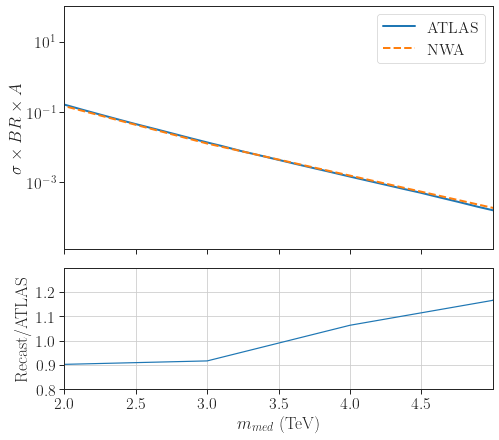

In [42]:
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(7,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].plot(atlas_data['mMed'],atlas_data['sigmaBRAcc'],linewidth=2,label='ATLAS')

x = []
y = []
for mMed in acc:
    x.append(mMed/1e3)
    y.append(xsec[mMed]*br[mMed]*acc[mMed])
    
axarr[0].plot(x,y,label='NWA',linewidth=2,linestyle='dashed')    

ratio = np.array(y)/atlasF(x)
axarr[1].plot(x,ratio)

axarr[1].set_yticks(np.arange(0.8,1.3,0.1))
axarr[1].set_ylim(0.8,1.3)
axarr[1].grid()

axarr[0].set_yscale('log')
axarr[1].set_xlabel(r'$m_{med}$ (TeV)')
axarr[0].set_ylabel(r'$\sigma \times BR \times A$')
axarr[1].set_xticks(np.arange(2.,5.,0.5))
axarr[1].set_xlim(2.0,5.0)

axarr[0].legend()
axarr[1].set_ylabel('Recast/ATLAS')

plt.show()

### Plot Jet Distributions

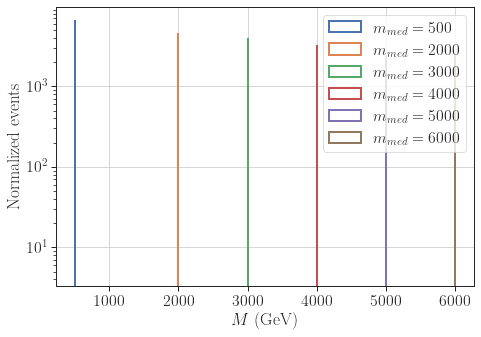

In [4]:
colors = sns.color_palette('deep',10)
fig = plt.figure(figsize=(7,5))

nplots = 0
for mMed,mvals in mList.items():    
    h,_,_ = plt.hist(mvals,label=r'$m_{med} = %1.0f$' %mMed,histtype='step',
                  linewidth=2,bins=50,density=True,color=colors[nplots])
    nplots += 1
    

plt.legend()
plt.yscale('log')
plt.grid()

plt.xlabel(r'$M$ (GeV)')
plt.ylabel('Normalized events')
plt.tight_layout()
plt.show()

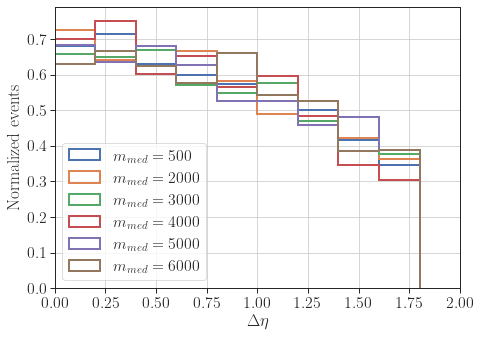

In [5]:
colors = sns.color_palette('deep',10)
fig = plt.figure(figsize=(7,5))

nplots = 0
for mMed,mvals in deltaEta.items():    
    h,_,_ = plt.hist(mvals,label=r'$m_{med} = %1.0f$' %mMed,histtype='step',
                  linewidth=2,bins=np.arange(0.,2.,0.2),density=True,color=colors[nplots])
    nplots += 1
    


plt.xlim(0.,2.)
# plt.yscale('log')
plt.grid()
plt.legend(loc='lower left')
plt.xlabel(r'$\Delta \eta$')
plt.ylabel('Normalized events')
plt.tight_layout()
plt.show()

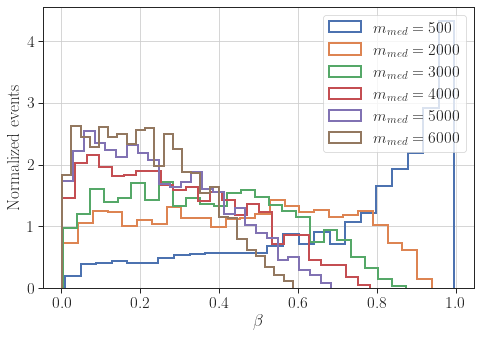

In [6]:
colors = sns.color_palette('deep',10)
fig = plt.figure(figsize=(7,5))

nplots = 0
for mMed,mvals in zboost.items():    
    h,_,_ = plt.hist(mvals,label=r'$m_{med} = %1.0f$' %mMed,histtype='step',
                  linewidth=2,bins=25,density=True,color=colors[nplots])
    nplots += 1
    

plt.legend()
# plt.yscale('log')
plt.grid()

plt.xlabel(r'$\beta$')
plt.ylabel('Normalized events')
plt.tight_layout()
plt.show()